In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import numpy.random as npr
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
plt.style.use('bmh')

In [2]:
#!pip install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

In [3]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']

print(data_train.shape, labels_train.shape)

(270000, 3124) (3124,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data_train.transpose(), labels_train, test_size=0.20)

X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train = np.resize(X_train,(2499,300,300,3))
X_test = np.resize(X_test,(625,300,300,3))
y_train_new = y_train - 1
y_test_new = y_test - 1
print(y_train_new)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_new))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_new))

(2499, 270000)
(625, 270000)
(2499,)
(625,)
[0. 0. 7. ... 8. 2. 0.]


In [5]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(300,
                                  300,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

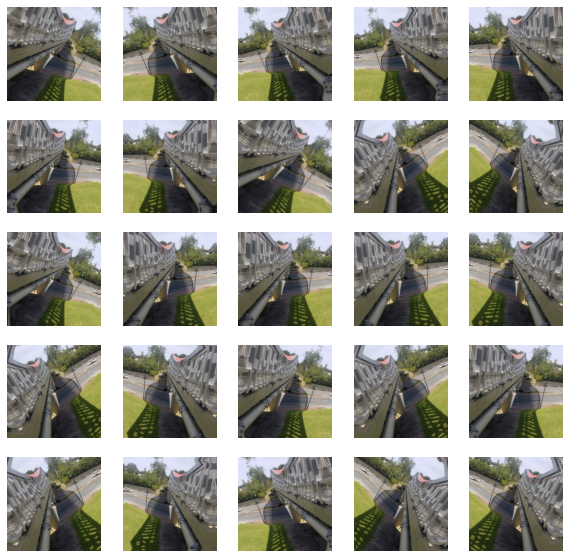

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(25):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
num_classes = 10

model_aug = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_filepath = 'model_1024.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

epochs=80
history = model_aug.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs,
  callbacks = [model_checkpoint_callback]
)

Epoch 1/80
10/40 [======>.......................] - ETA: 1:45 - loss: 2.3322 - accuracy: 0.1031

KeyboardInterrupt: 

In [ ]:
# this gives the prediction confidence
model_new = tf.keras.models.load_model('model_1024.h5')
predictions = model_new.predict(X_test)
scores_cnn = tf.nn.softmax(predictions)
scores_cnn_np = np.array(scores_cnn)

In [ ]:
final_scores = scores_cnn_np
num_pred = final_scores.shape[0]
final_predictions = np.zeros(num_pred)
#final_scores.shape
for i in range(num_pred):
    index = np.where(final_scores[i,:] == np.amax(final_scores[i,:]))
    #print(index)
    final_predictions[i] = index[0] + 1
    
#final_predictions

conf_matrix_boost = confusion_matrix(y_test, final_predictions)
class_report_boost = classification_report(y_test, final_predictions)
print(conf_matrix_boost)
print(class_report_boost)

In [ ]:
final_scores[0,:]
model_aug.save_weights('./checkpoints/my_checkpoint')